# Week 6: LangGraph 에이전트 아키텍처 I - 계획-실행 반복 + Tool Calling

## 과제 개요
- **주제**: Plan-Execute 에이전트 루프 구현
- **목표**: 도구를 활용하여 복잡한 요청을 단계별로 처리하는 에이전트 설계
- **핵심**: 고정 경로(5주차) → 동적 반복 루프(6주차)

## 5주차 vs 6주차

| 항목 | 5주차 | 6주차 |
|------|-------|-------|
| 아키텍처 | 고정 경로 분기 | 동적 반복 루프 |
| 처리 | 1회 실행 | 다중 반복 (Plan → Act → Observe) |
| 도구 | Retriever만 | 외부 Tool 다수 |
| 분기 | 3갈래 고정 | 반복 + 조건부 |

## 에이전트 루프 구조
```
사용자 요청
    ↓
[Plan] 실행 계획 수립
    ↓
[Act] 도구 실행
    ↓
[Observe] 결과 확인
    ↓ (충분?)
  NO → [Refine] 재계획
    ↓
  YES → 최종 답변
```

## 구현 내용
1. **Section 0**: 환경 설정 + Tool 구현 (3개 필수)
2. **Section 1**: AgentState 설계
3. **Section 2**: Agent 노드 구현 (Plan, Act, Observe, Refine)
4. **Section 3**: 반복 루프 그래프 구성
5. **Section 4**: 시나리오 테스트 (4개)

In [1]:
print("="*80)
print("Cell 2: 라이브러리 Import")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 기본 라이브러리
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# LangChain Core (5주차 재사용)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# LangChain Tools (6주차 핵심!)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

from langchain.tools import Tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import OpenWeatherMapAPIWrapper

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# LangGraph (5주차 재사용)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode  # 🆕 Tool 실행 헬퍼
from typing import TypedDict, Annotated, Literal
from langgraph.graph.message import add_messages

print("✅ 라이브러리 Import 완료")

print("""
[6주차 새로운 Import]
  - Tool: 도구 정의
  - TavilySearchResults: 웹 검색 도구
  - OpenWeatherMapAPIWrapper: 날씨 API
  - ToolNode: LangGraph의 도구 실행 헬퍼 (편리!)
  
[5주차에서 재사용]
  - ChatOpenAI, PromptTemplate
  - StateGraph, MemorySaver
  - add_messages
""")

Cell 2: 라이브러리 Import
✅ 라이브러리 Import 완료

[6주차 새로운 Import]
  - Tool: 도구 정의
  - TavilySearchResults: 웹 검색 도구
  - OpenWeatherMapAPIWrapper: 날씨 API
  - ToolNode: LangGraph의 도구 실행 헬퍼 (편리!)

[5주차에서 재사용]
  - ChatOpenAI, PromptTemplate
  - StateGraph, MemorySaver
  - add_messages



In [4]:
print("\n" + "="*80)
print("Cell 3: API 키 로드")
print("="*80)

# API 키 로드
load_dotenv()

# OpenAI API (5주차와 동일)
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found in .env file")
print("✅ OpenAI API 키 로드 완료")

# Tavily API (6주차 추가)
tavily_api_key = os.getenv("TAVILY_API_KEY")
if not tavily_api_key:
    print("⚠️ TAVILY_API_KEY not found - 웹 검색 도구를 사용할 수 없습니다")
    print("   https://tavily.com 에서 무료 API 키를 발급받으세요")
else:
    print("✅ Tavily API 키 로드 완료")

# OpenWeatherMap API (6주차 추가)
weather_api_key = os.getenv("OPENWEATHERMAP_API_KEY")
if not weather_api_key:
    print("⚠️ OPENWEATHERMAP_API_KEY not found - 날씨 도구를 사용할 수 없습니다")
    print("   https://openweathermap.org/api 에서 무료 API 키를 발급받으세요")
else:
    print("✅ OpenWeatherMap API 키 로드 완료")

print("""
[필요한 API 키]
1. OPENAI_API_KEY (필수) - LLM 사용
2. TAVILY_API_KEY (권장) - 웹 검색 도구
3. OPENWEATHERMAP_API_KEY (권장) - 날씨 도구
""")


Cell 3: API 키 로드
✅ OpenAI API 키 로드 완료
✅ Tavily API 키 로드 완료
✅ OpenWeatherMap API 키 로드 완료

[필요한 API 키]
1. OPENAI_API_KEY (필수) - LLM 사용
2. TAVILY_API_KEY (권장) - 웹 검색 도구
3. OPENWEATHERMAP_API_KEY (권장) - 날씨 도구



In [5]:
print("\n" + "="*80)
print("Cell 4: LLM 설정")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# LLM 설정 (5주차와 동일)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

LLM_MODEL = "gpt-4o-mini"
LLM_TEMPERATURE = 0.1

llm = ChatOpenAI(
    model=LLM_MODEL,
    temperature=LLM_TEMPERATURE,
    api_key=openai_api_key
)

print(f"✅ LLM 설정 완료: {LLM_MODEL}")

print("""
[LLM 설정]
  - 모델: gpt-4o-mini
  - Temperature: 0.1
  - 용도: 계획 수립, 도구 호출 결정, 답변 생성
  
[6주차에서 LLM 역할]
  1. Plan: 실행 계획 수립
  2. Tool Calling: 어떤 도구를 호출할지 결정
  3. Refine: 중간 결과 보고 재계획
  4. Answer: 최종 답변 생성
""")


Cell 4: LLM 설정
✅ LLM 설정 완료: gpt-4o-mini

[LLM 설정]
  - 모델: gpt-4o-mini
  - Temperature: 0.1
  - 용도: 계획 수립, 도구 호출 결정, 답변 생성

[6주차에서 LLM 역할]
  1. Plan: 실행 계획 수립
  2. Tool Calling: 어떤 도구를 호출할지 결정
  3. Refine: 중간 결과 보고 재계획
  4. Answer: 최종 답변 생성



In [6]:
print("\n" + "="*80)
print("Cell 5: Tool 1 - 웹 검색 도구 (Tavily)")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 웹 검색 도구
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

if tavily_api_key:
    # Tavily 웹 검색
    tavily_search = TavilySearchResults(
        api_key=tavily_api_key,
        max_results=3  # 최대 3개 결과
    )
    
    web_search_tool = Tool(
        name="web_search",
        description="""
인터넷에서 최신 정보를 검색합니다.        
사용 시기:
- 최신 뉴스, 이벤트
- 사실 확인 (인물, 날짜, 통계)
- 일반 지식 (역사, 과학)

입력: 검색 쿼리 (문자열)
출력: 검색 결과 리스트

예시:
- "파이썬 창시자"
- "2024년 AI 뉴스"
- "서울 인구"
""",
        func=tavily_search.invoke
    )
    
    print("✅ 웹 검색 도구 생성 완료 (Tavily)")
    
    # 테스트
    print("\n[테스트] 쿼리: '파이썬 창시자'")
    test_result = web_search_tool.invoke("파이썬 창시자")
    print(f"  결과: {str(test_result)[:200]}...")
    
else:
    # Fallback: 더미 도구
    web_search_tool = Tool(
        name="web_search",
        description="웹 검색 (더미 버전 - API 키 없음)",
        func=lambda q: [{"content": f"'{q}'에 대한 검색 결과 (더미)"}]
    )
    print("⚠️ Tavily API 키 없음 - 더미 웹 검색 도구 사용")

print("""
[웹 검색 도구 특징]
  - 최신 정보 조회
  - 사실 확인
  - 일반 지식 검색
  
[Tavily 장점]
  - LLM 친화적 결과
  - 빠른 응답
  - 무료 티어 제공
""")


Cell 5: Tool 1 - 웹 검색 도구 (Tavily)
✅ 웹 검색 도구 생성 완료 (Tavily)

[테스트] 쿼리: '파이썬 창시자'
  결과: [{'title': 'Python 41 - 파이썬 의미, 창시자, 역사 - 디티트래커', 'url': 'https://xodud2972.tistory.com/50', 'content': '어떤 분야든 가리지 않고 닥치는대로 사용할 수있는 범용성 등 많은 무기를 가지고 있다.\n\n이 때문인지는 몰라도 2017년 6월 기준 프로그래밍 점유율 수준은 당당하게 ...

[웹 검색 도구 특징]
  - 최신 정보 조회
  - 사실 확인
  - 일반 지식 검색

[Tavily 장점]
  - LLM 친화적 결과
  - 빠른 응답
  - 무료 티어 제공



In [7]:
print("\n" + "="*80)
print("Cell 6: Tool 2 - 계산기 도구")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 계산기 도구
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

import re
from typing import Union

def safe_calculator(expression: str) -> Union[float, str]:
    """안전한 계산기 함수
    
    eval()을 사용하되 안전한 문자만 허용
    
    Args:
        expression: 수식 문자열 (예: "25 * 4")
        
    Returns:
        계산 결과 또는 에러 메시지
    """
    try:
        # 허용된 문자만 체크 (숫자, 연산자, 공백, 괄호, 소수점)
        if not re.match(r'^[\d\s\+\-\*\/\(\)\.]+$', expression):
            return f"Error: 허용되지 않은 문자 포함 - '{expression}'"
        
        # 계산 실행
        result = eval(expression)
        
        return float(result)
        
    except ZeroDivisionError:
        return "Error: 0으로 나눌 수 없습니다"
    except Exception as e:
        return f"Error: 계산 실패 - {str(e)}"

# Tool 생성
calculator_tool = Tool(
    name="calculator",
    description="""수학 계산을 수행합니다.

사용 시기:
- 사칙연산 (+, -, *, /)
- 복잡한 수식 계산
- 숫자 비교

입력: 수식 문자열
출력: 계산 결과 (숫자)

예시:
- "25 * 4"
- "(100 + 50) / 2"
- "2024 - 1956"

주의: 숫자와 연산자만 사용 가능
""",
    func=safe_calculator
)

print("✅ 계산기 도구 생성 완료")

# 테스트
print("\n[테스트 1] 수식: '25 * 4'")
result1 = calculator_tool.invoke("25 * 4")
print(f"  결과: {result1}")

print("\n[테스트 2] 수식: '(100 + 50) / 2'")
result2 = calculator_tool.invoke("(100 + 50) / 2")
print(f"  결과: {result2}")

print("\n[테스트 3] 수식: '2024 - 1956'")
result3 = calculator_tool.invoke("2024 - 1956")
print(f"  결과: {result3}")

print("""
[계산기 도구 특징]
  - 안전한 eval 사용
  - 허용된 문자만 처리
  - 에러 처리 포함
  
[지원 연산]
  - 사칙연산: +, -, *, /
  - 괄호: ( )
  - 소수점: .
""")


Cell 6: Tool 2 - 계산기 도구
✅ 계산기 도구 생성 완료

[테스트 1] 수식: '25 * 4'
  결과: 100.0

[테스트 2] 수식: '(100 + 50) / 2'
  결과: 75.0

[테스트 3] 수식: '2024 - 1956'
  결과: 68.0

[계산기 도구 특징]
  - 안전한 eval 사용
  - 허용된 문자만 처리
  - 에러 처리 포함

[지원 연산]
  - 사칙연산: +, -, *, /
  - 괄호: ( )
  - 소수점: .



In [11]:
print("\n" + "="*80)
print("Cell 7: Tool 3 - 날씨 도구 (OpenWeatherMap)")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 날씨 도구
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

if weather_api_key:
    # OpenWeatherMap API
    weather_wrapper = OpenWeatherMapAPIWrapper(
        openweathermap_api_key=weather_api_key
    )
    
    weather_tool = Tool(
        name="weather",
        description="""도시의 현재 날씨 정보를 조회합니다.

사용 시기:
- 특정 도시의 날씨 확인
- 기온, 습도, 날씨 상태 조회

입력: 도시 이름 (영어 또는 한글)
출력: 날씨 정보 (기온, 상태, 습도 등)

예시:
- "Seoul"
- "New York"
- "Tokyo"

주의: 도시 이름만 입력 (국가 코드 불필요)
""",
        func=weather_wrapper.run
    )
    
    print("✅ 날씨 도구 생성 완료 (OpenWeatherMap)")
    
    # 테스트
    print("\n[테스트] 도시: 'New York'")
    test_result = weather_tool.invoke("New York")
    print(f"  결과: {test_result[:200]}...")
    
else:
    # Fallback: 더미 도구
    def dummy_weather(city: str) -> str:
        return f"{city}의 날씨: 맑음, 기온 20°C (더미 데이터 - API 키 없음)"
    
    weather_tool = Tool(
        name="weather",
        description="날씨 조회 (더미 버전 - API 키 없음)",
        func=dummy_weather
    )
    print("⚠️ OpenWeatherMap API 키 없음 - 더미 날씨 도구 사용")

print("""
[날씨 도구 특징]
  - 실시간 날씨 조회
  - 전 세계 도시 지원
  - 기온, 습도, 날씨 상태
  
[OpenWeatherMap]
  - 무료 티어: 1분당 60회 호출
  - 현재 날씨 + 예보
""")


Cell 7: Tool 3 - 날씨 도구 (OpenWeatherMap)
✅ 날씨 도구 생성 완료 (OpenWeatherMap)

[테스트] 도시: 'New York'
  결과: In New York, the current weather is as follows:
Detailed status: clear sky
Wind speed: 2.68 m/s, direction: 347°
Humidity: 81%
Temperature: 
  - Current: -5.29°C
  - High: -3.89°C
  - Low: -7.27°C
  -...

[날씨 도구 특징]
  - 실시간 날씨 조회
  - 전 세계 도시 지원
  - 기온, 습도, 날씨 상태

[OpenWeatherMap]
  - 무료 티어: 1분당 60회 호출
  - 현재 날씨 + 예보



In [12]:
print("\n" + "="*80)
print("Cell 8: Tools 리스트 정리 및 확인")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Tools 리스트 생성
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

tools = [web_search_tool, calculator_tool, weather_tool]

print(f"✅ 총 {len(tools)}개 도구 등록 완료\n")

# 도구 정보 출력
print("등록된 도구 목록:")
print("-" * 80)
for i, tool in enumerate(tools, 1):
    print(f"{i}. {tool.name}")
    print(f"   설명: {tool.description.split(chr(10))[0]}")  # 첫 줄만
    print()
print("-" * 80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# LLM에 Tools 바인딩 (중요!)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

llm_with_tools = llm.bind_tools(tools)

print("\n✅ LLM에 도구 바인딩 완료")

print("""
[LLM Tool Binding 설명]
  - llm.bind_tools(tools): LLM이 도구 호출 가능하도록 설정
  - LLM이 응답 시 tool_calls 필드에 호출 정보 포함
  
[Tool Calling 흐름]
  1. 사용자: "서울 날씨 알려줘"
  2. LLM: "weather 도구를 Seoul로 호출해야겠다"
  3. tool_calls: [{"name": "weather", "args": {"city": "Seoul"}}]
  4. 도구 실행: weather("Seoul")
  5. 결과: "서울 날씨: 맑음, 20°C..."
  6. LLM: 결과를 보고 최종 답변 생성
""")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Tool Calling 간단 테스트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n" + "="*80)
print("Tool Calling 테스트")
print("="*80)

test_message = "25 곱하기 4는 얼마야?"
print(f"\n질문: {test_message}")

response = llm_with_tools.invoke([HumanMessage(content=test_message)])

print(f"\nLLM 응답 타입: {type(response)}")

if response.tool_calls:
    print(f"\n✅ 도구 호출 감지!")
    for tool_call in response.tool_calls:
        print(f"  - 도구: {tool_call['name']}")
        print(f"  - 인자: {tool_call['args']}")
else:
    print(f"\n답변: {response.content}")

print("""
[Tool Calling 동작 확인]
  - LLM이 자동으로 calculator 도구를 선택했는지 확인
  - tool_calls 필드에 호출 정보가 있어야 함
  
다음 단계: AgentState 설계
""")


Cell 8: Tools 리스트 정리 및 확인
✅ 총 3개 도구 등록 완료

등록된 도구 목록:
--------------------------------------------------------------------------------
1. web_search
   설명: 

2. calculator
   설명: 수학 계산을 수행합니다.

3. weather
   설명: 도시의 현재 날씨 정보를 조회합니다.

--------------------------------------------------------------------------------

✅ LLM에 도구 바인딩 완료

[LLM Tool Binding 설명]
  - llm.bind_tools(tools): LLM이 도구 호출 가능하도록 설정
  - LLM이 응답 시 tool_calls 필드에 호출 정보 포함

[Tool Calling 흐름]
  1. 사용자: "서울 날씨 알려줘"
  2. LLM: "weather 도구를 Seoul로 호출해야겠다"
  3. tool_calls: [{"name": "weather", "args": {"city": "Seoul"}}]
  4. 도구 실행: weather("Seoul")
  5. 결과: "서울 날씨: 맑음, 20°C..."
  6. LLM: 결과를 보고 최종 답변 생성


Tool Calling 테스트

질문: 25 곱하기 4는 얼마야?

LLM 응답 타입: <class 'langchain_core.messages.ai.AIMessage'>

✅ 도구 호출 감지!
  - 도구: calculator
  - 인자: {'__arg1': '25 * 4'}

[Tool Calling 동작 확인]
  - LLM이 자동으로 calculator 도구를 선택했는지 확인
  - tool_calls 필드에 호출 정보가 있어야 함

다음 단계: AgentState 설계



---
# Section 1: AgentState 설계
---

## 목표
- ChatState(5주차) → AgentState(6주차) 확장
- Plan-Execute 루프에 필요한 필드 추가
- 중간 결과 및 도구 호출 이력 관리

## 5주차 vs 6주차 State 비교

### 5주차 ChatState (고정 경로)
```python
class ChatState(TypedDict):
    messages: list[BaseMessage]  # 대화 히스토리
    query: str                   # 사용자 질문
    intent: str                  # 분류된 의도
    context: str                 # RAG 검색 결과
```

### 6주차 AgentState (반복 루프)
```python
class AgentState(TypedDict):
    messages: list[BaseMessage]  # 대화 히스토리 (동일)
    query: str                   # 사용자 질문 (동일)
    plan: str                    # 🆕 실행 계획
    current_step: int            # 🆕 현재 단계 (1, 2, 3...)
    intermediate_steps: list     # 🆕 중간 결과 [(action, observation)]
    tool_calls: list             # 🆕 호출된 도구 리스트
    final_answer: str            # 🆕 최종 답변
```

## 핵심 필드 설명

1. **plan**: LLM이 생성한 실행 계획
   - 예: "1. 웹 검색으로 파이썬 창시자 찾기\n2. 계산기로 나이 계산"

2. **current_step**: 현재 진행 중인 단계 번호
   - 무한 루프 방지 (MAX_ITERATIONS)

3. **intermediate_steps**: ReAct 패턴의 핵심
   - [(action, observation), ...]
   - 예: [("web_search('파이썬 창시자')", "Guido van Rossum")]

4. **tool_calls**: 호출된 도구 메타데이터
   - LLM의 tool_calls 응답 저장

5. **final_answer**: 모든 단계 완료 후 최종 답변

In [13]:
print("="*80)
print("Cell 11: AgentState 정의")
print("="*80)

from typing import TypedDict, Annotated, Any
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# AgentState 정의
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

class AgentState(TypedDict):
    """LangGraph 에이전트 State
    
    Plan-Execute 반복 루프를 위한 상태 관리
    
    Attributes:
        messages: 대화 메시지 리스트 (자동 누적)
        query: 사용자의 현재 질문
        plan: LLM이 생성한 실행 계획
        current_step: 현재 진행 중인 단계 번호 (1, 2, 3, ...)
        intermediate_steps: 중간 실행 결과 [(action, observation), ...]
        tool_calls: LLM이 호출한 도구 정보
        final_answer: 모든 단계 완료 후 최종 답변
    """
    # 5주차에서 재사용
    messages: Annotated[list[BaseMessage], add_messages]
    query: str
    
    # 6주차 추가 필드
    plan: str
    current_step: int
    intermediate_steps: list[tuple[str, str]]  # [(action, observation), ...]
    tool_calls: list[dict[str, Any]]
    final_answer: str

print("✅ AgentState 정의 완료")

print("""
[AgentState 필드 상세]

1. messages (5주차 재사용)
   - 타입: list[BaseMessage]
   - 역할: 대화 히스토리 자동 누적
   - Annotated[..., add_messages]: LangGraph 자동 병합

2. query (5주차 재사용)
   - 타입: str
   - 역할: 사용자의 현재 질문

3. plan (6주차 신규) ⭐
   - 타입: str
   - 역할: 실행 계획 저장
   - 예시: "1. 웹 검색\n2. 계산\n3. 답변 생성"

4. current_step (6주차 신규)
   - 타입: int
   - 역할: 현재 단계 번호 (무한 루프 방지)
   - 범위: 1 ~ MAX_ITERATIONS

5. intermediate_steps (6주차 신규) ⭐⭐
   - 타입: list[tuple[str, str]]
   - 역할: ReAct 패턴의 핵심
   - 형식: [(action, observation), ...]
   - 예시: [
       ("web_search('파이썬 창시자')", "Guido van Rossum"),
       ("calculator('2024 - 1956')", "68")
     ]

6. tool_calls (6주차 신규)
   - 타입: list[dict]
   - 역할: LLM의 tool_calls 메타데이터 저장
   - 형식: [{"name": "calculator", "args": {"expression": "25 * 4"}}]

7. final_answer (6주차 신규)
   - 타입: str
   - 역할: 최종 답변 (루프 종료 조건)
""")

Cell 11: AgentState 정의
✅ AgentState 정의 완료

[AgentState 필드 상세]

1. messages (5주차 재사용)
   - 타입: list[BaseMessage]
   - 역할: 대화 히스토리 자동 누적
   - Annotated[..., add_messages]: LangGraph 자동 병합

2. query (5주차 재사용)
   - 타입: str
   - 역할: 사용자의 현재 질문

3. plan (6주차 신규) ⭐
   - 타입: str
   - 역할: 실행 계획 저장
   - 예시: "1. 웹 검색
2. 계산
3. 답변 생성"

4. current_step (6주차 신규)
   - 타입: int
   - 역할: 현재 단계 번호 (무한 루프 방지)
   - 범위: 1 ~ MAX_ITERATIONS

5. intermediate_steps (6주차 신규) ⭐⭐
   - 타입: list[tuple[str, str]]
   - 역할: ReAct 패턴의 핵심
   - 형식: [(action, observation), ...]
   - 예시: [
       ("web_search('파이썬 창시자')", "Guido van Rossum"),
       ("calculator('2024 - 1956')", "68")
     ]

6. tool_calls (6주차 신규)
   - 타입: list[dict]
   - 역할: LLM의 tool_calls 메타데이터 저장
   - 형식: [{"name": "calculator", "args": {"expression": "25 * 4"}}]

7. final_answer (6주차 신규)
   - 타입: str
   - 역할: 최종 답변 (루프 종료 조건)



In [14]:
print("\n" + "="*80)
print("Cell 12: AgentState 초기화 함수")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# AgentState 초기화 헬퍼 함수
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

def create_initial_state(user_query: str) -> AgentState:
    """AgentState 초기 상태 생성
    
    Args:
        user_query: 사용자 질문
        
    Returns:
        초기화된 AgentState
    """
    return {
        "messages": [HumanMessage(content=user_query)],
        "query": user_query,
        "plan": "",
        "current_step": 0,
        "intermediate_steps": [],
        "tool_calls": [],
        "final_answer": ""
    }

print("✅ AgentState 초기화 함수 정의 완료")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 테스트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

test_query = "서울 날씨 알려줘"
test_state = create_initial_state(test_query)

print(f"\n[테스트] 초기 State 생성: '{test_query}'")
print("-" * 80)
print(f"messages: {len(test_state['messages'])}개")
print(f"query: {test_state['query']}")
print(f"plan: '{test_state['plan']}'")
print(f"current_step: {test_state['current_step']}")
print(f"intermediate_steps: {test_state['intermediate_steps']}")
print(f"tool_calls: {test_state['tool_calls']}")
print(f"final_answer: '{test_state['final_answer']}'")
print("-" * 80)

print("""
[초기 State 특징]
  ✅ messages: 사용자 질문 1개
  ✅ query: 사용자 질문 저장
  ✅ plan: 빈 문자열 (plan_node에서 생성)
  ✅ current_step: 0 (아직 시작 전)
  ✅ intermediate_steps: 빈 리스트
  ✅ tool_calls: 빈 리스트
  ✅ final_answer: 빈 문자열 (루프 완료 후 생성)
""")


Cell 12: AgentState 초기화 함수
✅ AgentState 초기화 함수 정의 완료

[테스트] 초기 State 생성: '서울 날씨 알려줘'
--------------------------------------------------------------------------------
messages: 1개
query: 서울 날씨 알려줘
plan: ''
current_step: 0
intermediate_steps: []
tool_calls: []
final_answer: ''
--------------------------------------------------------------------------------

[초기 State 특징]
  ✅ messages: 사용자 질문 1개
  ✅ query: 사용자 질문 저장
  ✅ plan: 빈 문자열 (plan_node에서 생성)
  ✅ current_step: 0 (아직 시작 전)
  ✅ intermediate_steps: 빈 리스트
  ✅ tool_calls: 빈 리스트
  ✅ final_answer: 빈 문자열 (루프 완료 후 생성)



In [15]:
print("\n" + "="*80)
print("Cell 13: 상수 정의 (에이전트 설정)")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 에이전트 설정 상수
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# 최대 반복 횟수 (무한 루프 방지)
MAX_ITERATIONS = 5

# Tool-First 키워드 (특정 단어 감지 시 해당 도구 우선 호출)
TOOL_FIRST_KEYWORDS = {
    "날씨": "weather",
    "weather": "weather",
    "기온": "weather",
    "온도": "weather",
    "계산": "calculator",
    "곱하기": "calculator",
    "더하기": "calculator",
    "빼기": "calculator",
    "나누기": "calculator",
}

print(f"✅ 에이전트 설정 완료")
print(f"\n[설정값]")
print(f"  - MAX_ITERATIONS: {MAX_ITERATIONS}")
print(f"  - TOOL_FIRST_KEYWORDS: {len(TOOL_FIRST_KEYWORDS)}개 키워드")

print(f"\n[Tool-First 키워드 목록]")
print("-" * 80)
for keyword, tool in TOOL_FIRST_KEYWORDS.items():
    print(f"  '{keyword}' → {tool} 도구")
print("-" * 80)

print("""
[설정 설명]

1. MAX_ITERATIONS (최대 반복 횟수)
   - 목적: 무한 루프 방지
   - 기본값: 5회
   - 동작: current_step >= MAX_ITERATIONS이면 강제 종료

2. TOOL_FIRST_KEYWORDS (도구 우선 호출)
   - 목적: 특정 키워드 감지 시 LLM 거치지 않고 즉시 도구 호출
   - 예시:
     * "서울 날씨 알려줘" → '날씨' 감지 → weather 도구 즉시 호출
     * "25 곱하기 4" → '곱하기' 감지 → calculator 도구 즉시 호출
   - 장점: 응답 속도 향상, LLM 호출 절약

[다음 단계]
  - plan_node에서 TOOL_FIRST_KEYWORDS 활용
  - check_result_node에서 MAX_ITERATIONS 체크
""")


Cell 13: 상수 정의 (에이전트 설정)
✅ 에이전트 설정 완료

[설정값]
  - MAX_ITERATIONS: 5
  - TOOL_FIRST_KEYWORDS: 9개 키워드

[Tool-First 키워드 목록]
--------------------------------------------------------------------------------
  '날씨' → weather 도구
  'weather' → weather 도구
  '기온' → weather 도구
  '온도' → weather 도구
  '계산' → calculator 도구
  '곱하기' → calculator 도구
  '더하기' → calculator 도구
  '빼기' → calculator 도구
  '나누기' → calculator 도구
--------------------------------------------------------------------------------

[설정 설명]

1. MAX_ITERATIONS (최대 반복 횟수)
   - 목적: 무한 루프 방지
   - 기본값: 5회
   - 동작: current_step >= MAX_ITERATIONS이면 강제 종료

2. TOOL_FIRST_KEYWORDS (도구 우선 호출)
   - 목적: 특정 키워드 감지 시 LLM 거치지 않고 즉시 도구 호출
   - 예시:
     * "서울 날씨 알려줘" → '날씨' 감지 → weather 도구 즉시 호출
     * "25 곱하기 4" → '곱하기' 감지 → calculator 도구 즉시 호출
   - 장점: 응답 속도 향상, LLM 호출 절약

[다음 단계]
  - plan_node에서 TOOL_FIRST_KEYWORDS 활용
  - check_result_node에서 MAX_ITERATIONS 체크



In [16]:
print("\n" + "="*80)
print("Section 1 완료 요약")
print("="*80)

print("""
✅ Section 1: AgentState 설계 완료

[구현 완료 항목]
1. ✅ AgentState 정의
   - 5주차 필드 재사용: messages, query
   - 6주차 신규 필드: plan, current_step, intermediate_steps, tool_calls, final_answer

2. ✅ 초기화 함수
   - create_initial_state(user_query)
   - 모든 필드 기본값 설정

3. ✅ 에이전트 설정
   - MAX_ITERATIONS: 5 (무한 루프 방지)
   - TOOL_FIRST_KEYWORDS: 도구 우선 호출 키워드

[5주차 대비 변경사항]

제거된 필드:
  ❌ intent: 고정 경로 분기에만 필요 (6주차는 동적 루프)
  ❌ context: RAG 전용 필드 (6주차는 Tool 사용)

추가된 필드:
  ✅ plan: 실행 계획
  ✅ current_step: 진행 단계
  ✅ intermediate_steps: ReAct 중간 결과
  ✅ tool_calls: 도구 호출 메타데이터
  ✅ final_answer: 최종 답변

[AgentState의 역할]

Plan-Execute 루프:
  1. plan_node: plan 생성
  2. tool_call_node: intermediate_steps 추가
  3. check_result_node: current_step 증가, final_answer 판단
  4. refine_node: plan 수정

[다음 단계]
Section 2: Agent 노드 구현
  - plan_node: 실행 계획 수립
  - tool_call_node: 도구 실행
  - check_result_node: 결과 검증
  - refine_node: 재계획
""")

print("\n" + "="*80)
print("현재 진행도: Section 1 완료 (40%)")
print("="*80)


Section 1 완료 요약

✅ Section 1: AgentState 설계 완료

[구현 완료 항목]
1. ✅ AgentState 정의
   - 5주차 필드 재사용: messages, query
   - 6주차 신규 필드: plan, current_step, intermediate_steps, tool_calls, final_answer

2. ✅ 초기화 함수
   - create_initial_state(user_query)
   - 모든 필드 기본값 설정

3. ✅ 에이전트 설정
   - MAX_ITERATIONS: 5 (무한 루프 방지)
   - TOOL_FIRST_KEYWORDS: 도구 우선 호출 키워드

[5주차 대비 변경사항]

제거된 필드:
  ❌ intent: 고정 경로 분기에만 필요 (6주차는 동적 루프)
  ❌ context: RAG 전용 필드 (6주차는 Tool 사용)

추가된 필드:
  ✅ plan: 실행 계획
  ✅ current_step: 진행 단계
  ✅ intermediate_steps: ReAct 중간 결과
  ✅ tool_calls: 도구 호출 메타데이터
  ✅ final_answer: 최종 답변

[AgentState의 역할]

Plan-Execute 루프:
  1. plan_node: plan 생성
  2. tool_call_node: intermediate_steps 추가
  3. check_result_node: current_step 증가, final_answer 판단
  4. refine_node: plan 수정

[다음 단계]
Section 2: Agent 노드 구현
  - plan_node: 실행 계획 수립
  - tool_call_node: 도구 실행
  - check_result_node: 결과 검증
  - refine_node: 재계획


현재 진행도: Section 1 완료 (40%)


---
# Section 2: Agent 노드 구현
---

## 목표
- Plan-Execute 루프의 4개 노드 구현
- ReAct 패턴 구현 (Reasoning + Acting)
- Tool Calling 통합

## 4개 노드 구조
```
┌─────────────┐
│ plan_node   │ 실행 계획 수립
└──────┬──────┘
       ↓
┌─────────────┐
│tool_call_node│ 도구 실행
└──────┬──────┘
       ↓
┌─────────────┐
│check_result │ 결과 검증
└──────┬──────┘
       ↓
    충분?
   /     \
 YES      NO
  ↓       ↓
 END  ┌─────────┐
      │ refine  │ 재계획
      └────┬────┘
           ↓
      tool_call_node (반복)
```

## 각 노드 역할

1. **plan_node**
   - 입력: query
   - 처리: 
     * Tool-First 키워드 체크
     * LLM으로 실행 계획 생성
   - 출력: plan 필드 업데이트

2. **tool_call_node**
   - 입력: plan, current_step
   - 처리:
     * LLM Tool Calling
     * 도구 실행
     * intermediate_steps 추가
   - 출력: intermediate_steps, tool_calls 업데이트

3. **check_result_node**
   - 입력: intermediate_steps
   - 처리:
     * 결과 충분한지 판단
     * MAX_ITERATIONS 체크
   - 출력: final_answer 또는 계속 진행

4. **refine_node**
   - 입력: plan, intermediate_steps
   - 처리:
     * 중간 결과 분석
     * 계획 수정
   - 출력: plan 업데이트

In [17]:
print("="*80)
print("Cell 16: plan_node 구현 (1/4)")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Plan Node용 프롬프트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

plan_template = """당신은 사용자의 요청을 분석하여 실행 계획을 수립하는 전문가입니다.

사용 가능한 도구:
1. web_search: 인터넷 검색 (최신 정보, 사실 확인)
2. calculator: 수학 계산 (사칙연산)
3. weather: 날씨 조회 (도시별 현재 날씨)

사용자 요청을 분석하고 단계별 실행 계획을 작성하세요.

규칙:
- 각 단계는 번호를 붙여 명확히 구분
- 어떤 도구를 사용할지 명시
- 도구 간 의존성 고려 (A 결과 → B 입력)
- 간결하고 실행 가능하게

사용자 요청: {query}

실행 계획:"""

plan_prompt = PromptTemplate(
    template=plan_template,
    input_variables=["query"]
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# plan_node 함수
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

def plan_node(state: AgentState) -> AgentState:
    """실행 계획 수립 노드
    
    1. Tool-First 키워드 체크
    2. LLM으로 실행 계획 생성
    3. plan 필드 업데이트
    
    Args:
        state: 현재 에이전트 상태
        
    Returns:
        업데이트된 상태 (plan)
    """
    query = state["query"]
    
    print(f"\n[Plan Node] 질문: '{query}'")
    
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    # Tool-First 체크 (특정 키워드 → 해당 도구 우선 사용)
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    tool_first = None
    for keyword, tool_name in TOOL_FIRST_KEYWORDS.items():
        if keyword in query:
            tool_first = tool_name
            print(f"  ✅ Tool-First 감지: '{keyword}' → {tool_name} 도구")
            break
    
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    # 실행 계획 생성
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    if tool_first:
        # Tool-First: 간단한 계획
        plan = f"1. {tool_first} 도구를 사용하여 '{query}' 처리"
        print(f"  ✅ Tool-First 계획 생성 (LLM 건너뜀)")
    else:
        # LLM으로 계획 생성
        print(f"  [1/2] LLM으로 실행 계획 생성 중...")
        plan = (plan_prompt | llm | StrOutputParser()).invoke({"query": query})
        print(f"  ✅ LLM 계획 생성 완료")
    
    print(f"\n  [실행 계획]")
    print(f"  {plan}")
    
    print(f"\n  [2/2] State 업데이트 중...")
    print(f"  ✅ plan_node 완료")
    
    return {
        "plan": plan,
        "current_step": 0  # 초기화
    }

print("✅ plan_node 구현 완료")

print("""
[plan_node 동작]
  1. Tool-First 키워드 체크
     - 날씨/계산 등 키워드 감지 시 해당 도구 우선
     - LLM 호출 생략 → 빠른 응답
  
  2. LLM 계획 생성
     - Tool-First 없을 때
     - 복잡한 요청 분석
  
  3. State 업데이트
     - plan: 실행 계획 저장
     - current_step: 0으로 초기화
""")

Cell 16: plan_node 구현 (1/4)
✅ plan_node 구현 완료

[plan_node 동작]
  1. Tool-First 키워드 체크
     - 날씨/계산 등 키워드 감지 시 해당 도구 우선
     - LLM 호출 생략 → 빠른 응답

  2. LLM 계획 생성
     - Tool-First 없을 때
     - 복잡한 요청 분석

  3. State 업데이트
     - plan: 실행 계획 저장
     - current_step: 0으로 초기화



In [18]:
print("\n" + "="*80)
print("Cell 17: tool_call_node 구현 (2/4)")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Tool Call Node용 프롬프트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

tool_call_template = """당신은 실행 계획에 따라 도구를 호출하는 에이전트입니다.

실행 계획:
{plan}

중간 결과:
{intermediate_steps}

현재 단계: {current_step}

다음에 실행할 도구를 선택하고 호출하세요.

규칙:
- 계획의 다음 단계 실행
- 이미 완료된 단계는 건너뛰기
- 중간 결과를 활용

사용자 요청: {query}"""

tool_call_prompt = PromptTemplate(
    template=tool_call_template,
    input_variables=["plan", "intermediate_steps", "current_step", "query"]
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# tool_call_node 함수
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

def tool_call_node(state: AgentState) -> AgentState:
    """도구 실행 노드
    
    1. LLM에게 계획과 중간 결과 전달
    2. LLM이 tool_calls로 도구 선택
    3. 선택된 도구 실행
    4. intermediate_steps에 결과 추가
    
    Args:
        state: 현재 에이전트 상태
        
    Returns:
        업데이트된 상태 (intermediate_steps, tool_calls, current_step)
    """
    query = state["query"]
    plan = state["plan"]
    current_step = state["current_step"]
    intermediate_steps = state["intermediate_steps"]
    
    print(f"\n[Tool Call Node] Step {current_step + 1}")
    
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    # 중간 결과 포맷팅
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    steps_text = "\n".join([
        f"Step {i+1}: {action} → {observation}"
        for i, (action, observation) in enumerate(intermediate_steps)
    ]) if intermediate_steps else "없음"
    
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    # LLM Tool Calling
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    print(f"  [1/3] LLM Tool Calling 중...")
    
    prompt_text = tool_call_prompt.format(
        plan=plan,
        intermediate_steps=steps_text,
        current_step=current_step,
        query=query
    )
    
    response = llm_with_tools.invoke([HumanMessage(content=prompt_text)])
    
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    # 도구 실행
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    if not response.tool_calls:
        print(f"  ⚠️ 도구 호출 없음 - LLM이 직접 답변 생성")
        return {
            "final_answer": response.content,
            "current_step": current_step + 1
        }
    
    print(f"  ✅ {len(response.tool_calls)}개 도구 호출 감지")
    
    new_steps = []
    new_tool_calls = []
    
    for tool_call in response.tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        
        print(f"\n  [2/3] 도구 실행: {tool_name}")
        print(f"    인자: {tool_args}")
        
        # 도구 찾기
        tool = next((t for t in tools if t.name == tool_name), None)
        
        if not tool:
            observation = f"Error: '{tool_name}' 도구를 찾을 수 없습니다"
            print(f"    ❌ {observation}")
        else:
            try:
                # 도구 실행
                # 대부분의 도구는 단일 인자를 받음
                if len(tool_args) == 1:
                    arg_value = list(tool_args.values())[0]
                    observation = str(tool.invoke(arg_value))
                else:
                    observation = str(tool.invoke(tool_args))
                
                print(f"    ✅ 결과: {observation[:100]}...")
                
            except Exception as e:
                observation = f"Error: {str(e)}"
                print(f"    ❌ 오류: {observation}")
        
        # 중간 결과 저장
        action = f"{tool_name}({tool_args})"
        new_steps.append((action, observation))
        new_tool_calls.append(tool_call)
    
    print(f"\n  [3/3] State 업데이트 중...")
    print(f"  ✅ tool_call_node 완료 ({len(new_steps)}개 도구 실행)")
    
    return {
        "intermediate_steps": intermediate_steps + new_steps,
        "tool_calls": state.get("tool_calls", []) + new_tool_calls,
        "current_step": current_step + 1
    }

print("✅ tool_call_node 구현 완료")

print("""
[tool_call_node 동작]
  1. LLM Tool Calling
     - 계획 + 중간 결과 → LLM
     - LLM이 다음 도구 선택
  
  2. 도구 실행
     - tool_calls 파싱
     - 해당 도구 invoke
     - 에러 처리
  
  3. 결과 저장
     - intermediate_steps: [(action, observation)]
     - tool_calls: 메타데이터
     - current_step: 단계 증가
""")


Cell 17: tool_call_node 구현 (2/4)
✅ tool_call_node 구현 완료

[tool_call_node 동작]
  1. LLM Tool Calling
     - 계획 + 중간 결과 → LLM
     - LLM이 다음 도구 선택

  2. 도구 실행
     - tool_calls 파싱
     - 해당 도구 invoke
     - 에러 처리

  3. 결과 저장
     - intermediate_steps: [(action, observation)]
     - tool_calls: 메타데이터
     - current_step: 단계 증가



In [19]:
print("\n" + "="*80)
print("Cell 18: check_result_node 구현 (3/4)")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Check Result Node용 프롬프트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

check_template = """당신은 실행 결과를 검증하는 전문가입니다.

사용자 요청: {query}

실행 계획:
{plan}

중간 실행 결과:
{intermediate_steps}

위 결과로 사용자 요청에 충분히 답변할 수 있는지 판단하세요.

판단 기준:
1. 필요한 정보를 모두 수집했는가?
2. 계획의 모든 단계를 완료했는가?
3. 추가 도구 호출이 필요한가?

충분하면 "DONE"만 출력하고, 부족하면 "CONTINUE"만 출력하세요.
다른 말은 일체 하지 마세요.

판단:"""

check_prompt = PromptTemplate(
    template=check_template,
    input_variables=["query", "plan", "intermediate_steps"]
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# check_result_node 함수
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

def check_result_node(state: AgentState) -> AgentState:
    """결과 검증 노드
    
    1. 중간 결과가 충분한지 LLM으로 판단
    2. MAX_ITERATIONS 체크
    3. 충분하면 최종 답변 생성
    
    Args:
        state: 현재 에이전트 상태
        
    Returns:
        업데이트된 상태 (final_answer 또는 계속)
    """
    query = state["query"]
    plan = state["plan"]
    current_step = state["current_step"]
    intermediate_steps = state["intermediate_steps"]
    
    print(f"\n[Check Result Node] Step {current_step} 결과 검증")
    
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    # 최대 반복 횟수 체크
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    if current_step >= MAX_ITERATIONS:
        print(f"  ⚠️ 최대 반복 횟수 도달 ({MAX_ITERATIONS}회) - 강제 종료")
        
        # 현재까지 결과로 답변 생성
        steps_summary = "\n".join([
            f"- {action}: {observation}"
            for action, observation in intermediate_steps
        ])
        
        final_answer = f"""최대 반복 횟수에 도달했습니다.

수집된 정보:
{steps_summary}

위 정보를 바탕으로 답변드리면, 추가 정보가 필요할 수 있습니다."""
        
        return {"final_answer": final_answer}
    
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    # 중간 결과 포맷팅
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    steps_text = "\n".join([
        f"Step {i+1}: {action}\n  결과: {observation}"
        for i, (action, observation) in enumerate(intermediate_steps)
    ])
    
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    # LLM으로 결과 충분성 판단
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    print(f"  [1/2] LLM으로 결과 충분성 판단 중...")
    
    decision = (check_prompt | llm | StrOutputParser()).invoke({
        "query": query,
        "plan": plan,
        "intermediate_steps": steps_text
    })
    
    decision = decision.strip().upper()
    
    print(f"  ✅ LLM 판단: {decision}")
    
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    # 결과에 따라 처리
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    if decision == "DONE":
        print(f"  ✅ 충분한 정보 수집 완료 - 최종 답변 생성")
        
        # 최종 답변 생성 (중간 결과 종합)
        print(f"  [2/2] 최종 답변 생성 중...")
        
        answer_prompt = f"""사용자 요청: {query}

수집된 정보:
{steps_text}

위 정보를 종합하여 사용자 요청에 답변하세요.
간결하고 명확하게 작성하세요.

답변:"""
        
        final_answer = llm.invoke([HumanMessage(content=answer_prompt)]).content
        
        print(f"  ✅ 최종 답변 생성 완료")
        
        return {"final_answer": final_answer}
    
    else:
        print(f"  → 추가 도구 실행 필요 - refine_node로 이동")
        return {}  # 변경 없음 (refine_node로 이동)

print("✅ check_result_node 구현 완료")

print("""
[check_result_node 동작]
  1. 최대 반복 체크
     - current_step >= MAX_ITERATIONS
     - 초과 시 강제 종료
  
  2. LLM 판단
     - 중간 결과 충분? DONE / CONTINUE
     - DONE: 최종 답변 생성
     - CONTINUE: refine_node로
  
  3. 최종 답변 생성
     - 중간 결과 종합
     - 사용자에게 제시
""")


Cell 18: check_result_node 구현 (3/4)
✅ check_result_node 구현 완료

[check_result_node 동작]
  1. 최대 반복 체크
     - current_step >= MAX_ITERATIONS
     - 초과 시 강제 종료

  2. LLM 판단
     - 중간 결과 충분? DONE / CONTINUE
     - DONE: 최종 답변 생성
     - CONTINUE: refine_node로

  3. 최종 답변 생성
     - 중간 결과 종합
     - 사용자에게 제시



In [20]:
print("\n" + "="*80)
print("Cell 19: refine_node 구현 (4/4)")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Refine Node용 프롬프트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

refine_template = """당신은 실행 계획을 개선하는 전문가입니다.

사용자 요청: {query}

기존 계획:
{plan}

지금까지 실행 결과:
{intermediate_steps}

위 결과를 보고 다음 단계 계획을 수립하세요.

개선 방향:
1. 부족한 정보가 있으면 추가 도구 사용
2. 오류가 있었다면 다른 방법 시도
3. 의존성 고려 (A 결과 → B 입력)

다음 단계 계획:"""

refine_prompt = PromptTemplate(
    template=refine_template,
    input_variables=["query", "plan", "intermediate_steps"]
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# refine_node 함수
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

def refine_node(state: AgentState) -> AgentState:
    """계획 재수립 노드
    
    1. 중간 결과 분석
    2. LLM으로 다음 단계 계획 생성
    3. plan 필드 업데이트
    
    Args:
        state: 현재 에이전트 상태
        
    Returns:
        업데이트된 상태 (plan)
    """
    query = state["query"]
    plan = state["plan"]
    intermediate_steps = state["intermediate_steps"]
    
    print(f"\n[Refine Node] 계획 재수립")
    
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    # 중간 결과 포맷팅
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    steps_text = "\n".join([
        f"Step {i+1}: {action}\n  결과: {observation}"
        for i, (action, observation) in enumerate(intermediate_steps)
    ])
    
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    # LLM으로 다음 단계 계획
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    print(f"  [1/2] LLM으로 다음 단계 계획 중...")
    
    refined_plan = (refine_prompt | llm | StrOutputParser()).invoke({
        "query": query,
        "plan": plan,
        "intermediate_steps": steps_text
    })
    
    print(f"  ✅ 재수립된 계획:")
    print(f"  {refined_plan}")
    
    print(f"\n  [2/2] State 업데이트 중...")
    print(f"  ✅ refine_node 완료")
    
    return {
        "plan": refined_plan
    }

print("✅ refine_node 구현 완료")

print("""
[refine_node 동작]
  1. 중간 결과 분석
     - 지금까지 실행한 내용
     - 부족한 정보 파악
  
  2. 계획 재수립
     - LLM이 다음 단계 생성
     - 기존 결과 활용
  
  3. State 업데이트
     - plan: 새로운 계획
     - tool_call_node로 복귀
""")


Cell 19: refine_node 구현 (4/4)
✅ refine_node 구현 완료

[refine_node 동작]
  1. 중간 결과 분석
     - 지금까지 실행한 내용
     - 부족한 정보 파악

  2. 계획 재수립
     - LLM이 다음 단계 생성
     - 기존 결과 활용

  3. State 업데이트
     - plan: 새로운 계획
     - tool_call_node로 복귀



In [21]:
print("\n" + "="*80)
print("Cell 20: 4개 노드 요약 및 단독 테스트")
print("="*80)

print("""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
4개 Agent 노드 구현 완료
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. plan_node ✅
   - Tool-First 키워드 체크
   - LLM으로 실행 계획 생성
   - 출력: plan

2. tool_call_node ✅
   - LLM Tool Calling
   - 도구 실행
   - 출력: intermediate_steps, tool_calls, current_step

3. check_result_node ✅
   - 결과 충분성 판단 (DONE/CONTINUE)
   - MAX_ITERATIONS 체크
   - 출력: final_answer (충분한 경우)

4. refine_node ✅
   - 중간 결과 분석
   - 다음 단계 계획
   - 출력: plan (재수립)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 노드 단독 테스트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n" + "="*80)
print("노드 단독 테스트")
print("="*80)

# 테스트 1: plan_node
print("\n[테스트 1] plan_node")
print("-" * 80)

test_state_1 = create_initial_state("서울 날씨 알려줘")
result_1 = plan_node(test_state_1)

print(f"\n결과:")
print(f"  - plan: {result_1['plan'][:100]}...")
print(f"  - current_step: {result_1['current_step']}")

# 테스트 2: tool_call_node
print("\n" + "="*80)
print("[테스트 2] tool_call_node")
print("-" * 80)

test_state_2 = create_initial_state("25 곱하기 4는?")
test_state_2["plan"] = "1. calculator 도구로 25 * 4 계산"
test_state_2["current_step"] = 0

result_2 = tool_call_node(test_state_2)

print(f"\n결과:")
print(f"  - intermediate_steps: {len(result_2.get('intermediate_steps', []))}개")
if result_2.get('intermediate_steps'):
    action, obs = result_2['intermediate_steps'][0]
    print(f"    * {action} → {obs}")
print(f"  - current_step: {result_2['current_step']}")

print("\n" + "="*80)
print("✅ 노드 단독 테스트 완료")
print("="*80)

print("""
[테스트 결과 확인]
  ✅ plan_node: Tool-First 감지 및 계획 생성
  ✅ tool_call_node: 도구 실행 및 결과 저장

[다음 단계]
  - check_result_node, refine_node는 그래프에서 테스트
  - Section 3에서 전체 그래프 구성
""")


Cell 20: 4개 노드 요약 및 단독 테스트

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
4개 Agent 노드 구현 완료
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. plan_node ✅
   - Tool-First 키워드 체크
   - LLM으로 실행 계획 생성
   - 출력: plan

2. tool_call_node ✅
   - LLM Tool Calling
   - 도구 실행
   - 출력: intermediate_steps, tool_calls, current_step

3. check_result_node ✅
   - 결과 충분성 판단 (DONE/CONTINUE)
   - MAX_ITERATIONS 체크
   - 출력: final_answer (충분한 경우)

4. refine_node ✅
   - 중간 결과 분석
   - 다음 단계 계획
   - 출력: plan (재수립)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


노드 단독 테스트

[테스트 1] plan_node
--------------------------------------------------------------------------------

[Plan Node] 질문: '서울 날씨 알려줘'
  ✅ Tool-First 감지: '날씨' → weather 도구
  ✅ Tool-First 계획 생성 (LLM 건너뜀)

  [실행 계획]
  1. weather 도구를 사용하여 '서울 날씨 알려줘' 처리

  [2/2] State 업데이트 중...
  ✅ plan_node 완료

결과:
  - plan: 1. weather 도구를 사용하여 '서울 날씨 알려줘' 처리...
  - current_step: 0

[테스트

In [22]:
print("\n" + "="*80)
print("Section 2 완료 요약")
print("="*80)

print("""
✅ Section 2: Agent 노드 구현 완료

[구현 완료 항목]
1. ✅ plan_node
   - Tool-First 키워드 감지
   - LLM 실행 계획 생성
   - plan, current_step 업데이트

2. ✅ tool_call_node
   - LLM Tool Calling
   - 도구 실행 (순차/병렬)
   - intermediate_steps 추가

3. ✅ check_result_node
   - 결과 충분성 판단
   - MAX_ITERATIONS 체크
   - final_answer 생성

4. ✅ refine_node
   - 중간 결과 분석
   - 계획 재수립
   - plan 업데이트

[5주차 대비 변경사항]

5주차 노드 (고정 경로):
  - router: 의도 분류 (1회)
  - doc_qa/summary/small_talk: 처리 (1회)

6주차 노드 (반복 루프):
  - plan: 계획 수립
  - tool_call: 도구 실행 (반복)
  - check: 결과 검증 (반복)
  - refine: 재계획 (반복)

[Plan-Execute 루프]
  
  사용자 요청
      ↓
  plan_node (계획)
      ↓
  tool_call_node (실행)
      ↓
  check_result_node (검증)
      ↓
    충분?
   /     \
 YES      NO
  ↓       ↓
 END   refine_node
         ↓
    tool_call_node (반복)

[다음 단계]
Section 3: 반복 루프 그래프 구성
  - StateGraph 생성
  - 4개 노드 연결
  - 조건부 엣지 (반복 제어)
  - MemorySaver 추가
  - 그래프 컴파일
""")

print("\n" + "="*80)
print("현재 진행도: Section 2 완료 (60%)")
print("="*80)


Section 2 완료 요약

✅ Section 2: Agent 노드 구현 완료

[구현 완료 항목]
1. ✅ plan_node
   - Tool-First 키워드 감지
   - LLM 실행 계획 생성
   - plan, current_step 업데이트

2. ✅ tool_call_node
   - LLM Tool Calling
   - 도구 실행 (순차/병렬)
   - intermediate_steps 추가

3. ✅ check_result_node
   - 결과 충분성 판단
   - MAX_ITERATIONS 체크
   - final_answer 생성

4. ✅ refine_node
   - 중간 결과 분석
   - 계획 재수립
   - plan 업데이트

[5주차 대비 변경사항]

5주차 노드 (고정 경로):
  - router: 의도 분류 (1회)
  - doc_qa/summary/small_talk: 처리 (1회)

6주차 노드 (반복 루프):
  - plan: 계획 수립
  - tool_call: 도구 실행 (반복)
  - check: 결과 검증 (반복)
  - refine: 재계획 (반복)

[Plan-Execute 루프]

  사용자 요청
      ↓
  plan_node (계획)
      ↓
  tool_call_node (실행)
      ↓
  check_result_node (검증)
      ↓
    충분?
   /      YES      NO
  ↓       ↓
 END   refine_node
         ↓
    tool_call_node (반복)

[다음 단계]
Section 3: 반복 루프 그래프 구성
  - StateGraph 생성
  - 4개 노드 연결
  - 조건부 엣지 (반복 제어)
  - MemorySaver 추가
  - 그래프 컴파일


현재 진행도: Section 2 완료 (60%)


Section 3: 반복 루프 그래프 구성
Cell 22: Section 3 헤더
python# Markdown Cell
"""
---
# Section 3: 반복 루프 그래프 구성
---

## 목표
- StateGraph로 Plan-Execute 루프 구현
- 조건부 엣지로 반복 제어
- MemorySaver로 메모리 관리

## 5주차 vs 6주차 그래프 비교

### 5주차 (고정 경로)
```
START
  ↓
router (의도 분류)
  ↓
┌─────────┬──────────┬─────────────┐
│ doc_qa  │ summary  │ small_talk  │
└────┬────┴─────┬────┴──────┬──────┘
     ↓          ↓           ↓
    END        END         END
```

### 6주차 (반복 루프)
```
START
  ↓
plan (계획 수립)
  ↓
tool_call (도구 실행)
  ↓
check (결과 검증)
  ↓
충분? (조건부 엣지)
├─ YES → END
└─ NO → refine (재계획)
          ↓
    tool_call (반복)
```

## 핵심 차이점

1. **5주차**: 1회 실행 후 종료
2. **6주차**: 조건 만족까지 반복 (최대 5회)

## 조건부 엣지 함수
```python
def should_continue(state: AgentState) -> Literal["end", "refine"]:
    if state.get("final_answer"):
        return "end"      # 최종 답변 있음 → 종료
    else:
        return "refine"   # 추가 작업 필요 → 재계획
```

In [23]:
print("="*80)
print("Cell 23: 조건부 엣지 함수 정의")
print("="*80)

from typing import Literal

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 조건부 엣지 함수 (반복 루프 제어)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

def should_continue(state: AgentState) -> Literal["end", "refine"]:
    """반복 루프 계속 여부 결정
    
    check_result_node가 final_answer를 설정했는지 확인
    
    Args:
        state: 현재 에이전트 상태
        
    Returns:
        "end": 최종 답변 있음 → END로
        "refine": 추가 작업 필요 → refine_node로
    """
    final_answer = state.get("final_answer", "")
    
    if final_answer:
        print(f"\n[Route] 최종 답변 존재 → END")
        return "end"
    else:
        print(f"\n[Route] 추가 작업 필요 → refine_node")
        return "refine"

print("✅ 조건부 엣지 함수 정의 완료")

print("""
[조건부 엣지 동작]

check_result_node 실행 후:
  1. final_answer 있음?
     YES → should_continue() → "end" → END
     NO  → should_continue() → "refine" → refine_node

  2. refine_node → tool_call_node (반복)

  3. 최대 5회 반복 (MAX_ITERATIONS)

[5주차 대비 차이]

5주차 조건부 엣지:
  - route_by_intent(state)
  - intent 값에 따라 고정 경로 선택
  - 1회만 실행

6주차 조건부 엣지:
  - should_continue(state)
  - final_answer 유무로 반복 제어
  - 최대 5회 반복 가능
""")

Cell 23: 조건부 엣지 함수 정의
✅ 조건부 엣지 함수 정의 완료

[조건부 엣지 동작]

check_result_node 실행 후:
  1. final_answer 있음?
     YES → should_continue() → "end" → END
     NO  → should_continue() → "refine" → refine_node

  2. refine_node → tool_call_node (반복)

  3. 최대 5회 반복 (MAX_ITERATIONS)

[5주차 대비 차이]

5주차 조건부 엣지:
  - route_by_intent(state)
  - intent 값에 따라 고정 경로 선택
  - 1회만 실행

6주차 조건부 엣지:
  - should_continue(state)
  - final_answer 유무로 반복 제어
  - 최대 5회 반복 가능



In [24]:
print("\n" + "="*80)
print("Cell 24: StateGraph 구성")
print("="*80)

from langgraph.graph import StateGraph, START, END

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# StateGraph 생성
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[1/5] StateGraph 생성 중...")
agent_graph_builder = StateGraph(AgentState)
print("  ✅ StateGraph 생성 완료 (AgentState 기반)")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 노드 추가
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[2/5] 노드 추가 중...")

agent_graph_builder.add_node("plan", plan_node)
print("  ✅ 'plan' 노드 추가")

agent_graph_builder.add_node("tool_call", tool_call_node)
print("  ✅ 'tool_call' 노드 추가")

agent_graph_builder.add_node("check", check_result_node)
print("  ✅ 'check' 노드 추가")

agent_graph_builder.add_node("refine", refine_node)
print("  ✅ 'refine' 노드 추가")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 일반 엣지 추가
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[3/5] 일반 엣지 추가 중...")

# START → plan
agent_graph_builder.add_edge(START, "plan")
print("  ✅ START → plan")

# plan → tool_call
agent_graph_builder.add_edge("plan", "tool_call")
print("  ✅ plan → tool_call")

# tool_call → check
agent_graph_builder.add_edge("tool_call", "check")
print("  ✅ tool_call → check")

# refine → tool_call (반복)
agent_graph_builder.add_edge("refine", "tool_call")
print("  ✅ refine → tool_call (루프)")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 조건부 엣지 추가 (핵심!)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[4/5] 조건부 엣지 추가 중...")

# check → (END | refine)
agent_graph_builder.add_conditional_edges(
    "check",              # 출발 노드
    should_continue,      # 라우팅 함수
    {
        "end": END,       # final_answer 있음 → 종료
        "refine": "refine"  # 추가 작업 필요 → 재계획
    }
)
print("  ✅ check → (END | refine) 조건부 엣지 추가")

print("\n[5/5] 그래프 구성 완료")
print("  ✅ 총 4개 노드, 4개 일반 엣지, 1개 조건부 엣지")

print("\n" + "="*80)
print("✅ StateGraph 구성 완료")
print("="*80)

print("""
[그래프 구조]

  START
    ↓
  plan (계획 수립)
    ↓
  tool_call (도구 실행)
    ↓
  check (결과 검증)
    ↓
  조건부 엣지 (should_continue)
  ├─ final_answer 있음 → END
  └─ 추가 작업 필요 → refine
                         ↓
                    tool_call (반복)

[조건부 엣지 동작]
  1. check_result_node 실행
  2. should_continue() 호출
  3. final_answer 유무로 분기
     - 있음: END (종료)
     - 없음: refine → tool_call (반복)

[5주차 대비 차이]
  5주차: 고정 3갈래 분기 (1회)
  6주차: 반복 루프 (최대 5회)
""")


Cell 24: StateGraph 구성

[1/5] StateGraph 생성 중...
  ✅ StateGraph 생성 완료 (AgentState 기반)

[2/5] 노드 추가 중...
  ✅ 'plan' 노드 추가
  ✅ 'tool_call' 노드 추가
  ✅ 'check' 노드 추가
  ✅ 'refine' 노드 추가

[3/5] 일반 엣지 추가 중...
  ✅ START → plan
  ✅ plan → tool_call
  ✅ tool_call → check
  ✅ refine → tool_call (루프)

[4/5] 조건부 엣지 추가 중...
  ✅ check → (END | refine) 조건부 엣지 추가

[5/5] 그래프 구성 완료
  ✅ 총 4개 노드, 4개 일반 엣지, 1개 조건부 엣지

✅ StateGraph 구성 완료

[그래프 구조]

  START
    ↓
  plan (계획 수립)
    ↓
  tool_call (도구 실행)
    ↓
  check (결과 검증)
    ↓
  조건부 엣지 (should_continue)
  ├─ final_answer 있음 → END
  └─ 추가 작업 필요 → refine
                         ↓
                    tool_call (반복)

[조건부 엣지 동작]
  1. check_result_node 실행
  2. should_continue() 호출
  3. final_answer 유무로 분기
     - 있음: END (종료)
     - 없음: refine → tool_call (반복)

[5주차 대비 차이]
  5주차: 고정 3갈래 분기 (1회)
  6주차: 반복 루프 (최대 5회)



In [25]:
print("\n" + "="*80)
print("Cell 25: MemorySaver 추가 및 컴파일")
print("="*80)

from langgraph.checkpoint.memory import MemorySaver

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# MemorySaver 생성 (5주차 재사용)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[1/2] MemorySaver 생성 중...")
memory_saver = MemorySaver()
print("  ✅ MemorySaver 생성 완료 (인메모리)")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 그래프 컴파일
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[2/2] 그래프 컴파일 중...")
agent_app = agent_graph_builder.compile(checkpointer=memory_saver)
print("  ✅ 그래프 컴파일 완료")

print("\n" + "="*80)
print("✅ LangGraph Agent 준비 완료")
print("="*80)

print("""
[컴파일된 그래프 정보]
  - StateGraph: AgentState 기반
  - Checkpointer: MemorySaver (인메모리)
  - 노드 수: 4개 (plan, tool_call, check, refine)
  - 엣지: 일반 4개 + 조건부 1개
  - 반복 루프: check → refine → tool_call

[MemorySaver 역할]
  ✅ thread_id로 세션 구분
  ✅ 대화 상태 자동 저장
  ✅ 반복 루프 중 상태 유지
  
[5주차와 동일]
  - MemorySaver 사용법 동일
  - thread_id로 세션 관리
  - 인메모리 저장
""")


Cell 25: MemorySaver 추가 및 컴파일

[1/2] MemorySaver 생성 중...
  ✅ MemorySaver 생성 완료 (인메모리)

[2/2] 그래프 컴파일 중...
  ✅ 그래프 컴파일 완료

✅ LangGraph Agent 준비 완료

[컴파일된 그래프 정보]
  - StateGraph: AgentState 기반
  - Checkpointer: MemorySaver (인메모리)
  - 노드 수: 4개 (plan, tool_call, check, refine)
  - 엣지: 일반 4개 + 조건부 1개
  - 반복 루프: check → refine → tool_call

[MemorySaver 역할]
  ✅ thread_id로 세션 구분
  ✅ 대화 상태 자동 저장
  ✅ 반복 루프 중 상태 유지

[5주차와 동일]
  - MemorySaver 사용법 동일
  - thread_id로 세션 관리
  - 인메모리 저장




Cell 26: 그래프 시각화 (선택)

[1/2] Mermaid 다이어그램 생성 중...
  ✅ 다이어그램 생성 완료

[2/2] 그래프 시각화:


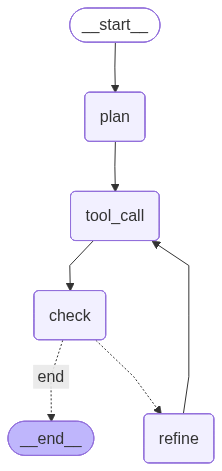


✅ 그래프 시각화 완료

[그래프 구조 설명]
  1. START: 그래프 시작
  2. plan: 실행 계획 수립
  3. tool_call: 도구 실행 (반복 가능)
  4. check: 결과 충분성 검증
  5. 조건부 엣지: final_answer 유무로 분기
     - 있음: END (종료)
     - 없음: refine → tool_call (반복)
  6. refine: 계획 재수립

[반복 루프]
  tool_call → check → refine → tool_call → ...
  (최대 5회 반복)



In [26]:
print("\n" + "="*80)
print("Cell 26: 그래프 시각화 (선택)")
print("="*80)

try:
    # Mermaid 다이어그램 생성
    print("\n[1/2] Mermaid 다이어그램 생성 중...")
    
    from IPython.display import Image, display
    
    # 그래프를 이미지로 변환
    graph_image = agent_app.get_graph().draw_mermaid_png()
    
    print("  ✅ 다이어그램 생성 완료")
    
    # 이미지 표시
    print("\n[2/2] 그래프 시각화:")
    display(Image(graph_image))
    
    print("\n✅ 그래프 시각화 완료")
    
except Exception as e:
    print(f"\n⚠️ 그래프 시각화 실패: {e}")
    print("\n대신 텍스트로 그래프 구조 출력:")
    print("""
    ┌─────────┐
    │  START  │
    └────┬────┘
         ↓
    ┌────────────┐
    │    plan    │ (계획 수립)
    └────┬───────┘
         ↓
    ┌────────────┐
    │ tool_call  │ (도구 실행)
    └────┬───────┘
         ↓
    ┌────────────┐
    │   check    │ (결과 검증)
    └────┬───────┘
         ↓ (조건부)
    final_answer?
    ├─ YES → END
    └─ NO → ┌───────────┐
            │  refine   │ (재계획)
            └─────┬─────┘
                  ↓
            tool_call (반복)
    """)

print("""
[그래프 구조 설명]
  1. START: 그래프 시작
  2. plan: 실행 계획 수립
  3. tool_call: 도구 실행 (반복 가능)
  4. check: 결과 충분성 검증
  5. 조건부 엣지: final_answer 유무로 분기
     - 있음: END (종료)
     - 없음: refine → tool_call (반복)
  6. refine: 계획 재수립
  
[반복 루프]
  tool_call → check → refine → tool_call → ...
  (최대 5회 반복)
""")

In [27]:
print("\n" + "="*80)
print("Cell 27: 단일 실행 테스트")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 테스트 실행
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

test_query = "25 곱하기 4는 얼마야?"
print(f"\n질문: {test_query}")

# thread_id 설정
config = {"configurable": {"thread_id": "test-agent-1"}}

# 초기 상태 생성
initial_state = create_initial_state(test_query)

print("\n" + "="*80)
print("그래프 실행 중...")
print("="*80)

# 그래프 실행
result = agent_app.invoke(initial_state, config=config)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 결과 출력
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n" + "="*80)
print("실행 결과")
print("="*80)

print(f"\n[최종 State]")
print(f"  - query: {result['query']}")
print(f"  - plan: {result['plan'][:100]}...")
print(f"  - current_step: {result['current_step']}")
print(f"  - intermediate_steps: {len(result['intermediate_steps'])}개")

if result['intermediate_steps']:
    print(f"\n[중간 실행 과정]")
    for i, (action, observation) in enumerate(result['intermediate_steps'], 1):
        print(f"  Step {i}: {action}")
        print(f"    → {observation[:100]}...")

print(f"\n[최종 답변]")
print(f"{result.get('final_answer', '답변 없음')}")

print("\n" + "="*80)
print("✅ 단일 실행 테스트 완료")
print("="*80)

print("""
[실행 흐름 확인]
  1. plan_node: Tool-First 감지 또는 계획 생성
  2. tool_call_node: calculator 도구 실행
  3. check_result_node: 결과 충분 판단
  4. final_answer 생성 또는 refine

[예상 동작]
  - "25 곱하기 4" → '곱하기' 키워드 감지
  - calculator 도구 즉시 호출
  - 결과: 100
  - 1회 실행으로 완료 (반복 불필요)
""")


Cell 27: 단일 실행 테스트

질문: 25 곱하기 4는 얼마야?

그래프 실행 중...

[Plan Node] 질문: '25 곱하기 4는 얼마야?'
  ✅ Tool-First 감지: '곱하기' → calculator 도구
  ✅ Tool-First 계획 생성 (LLM 건너뜀)

  [실행 계획]
  1. calculator 도구를 사용하여 '25 곱하기 4는 얼마야?' 처리

  [2/2] State 업데이트 중...
  ✅ plan_node 완료

[Tool Call Node] Step 1
  [1/3] LLM Tool Calling 중...
  ✅ 1개 도구 호출 감지

  [2/3] 도구 실행: calculator
    인자: {'__arg1': '25 * 4'}
    ✅ 결과: 100.0...

  [3/3] State 업데이트 중...
  ✅ tool_call_node 완료 (1개 도구 실행)

[Check Result Node] Step 1 결과 검증
  [1/2] LLM으로 결과 충분성 판단 중...
  ✅ LLM 판단: DONE
  ✅ 충분한 정보 수집 완료 - 최종 답변 생성
  [2/2] 최종 답변 생성 중...
  ✅ 최종 답변 생성 완료

[Route] 최종 답변 존재 → END

실행 결과

[최종 State]
  - query: 25 곱하기 4는 얼마야?
  - plan: 1. calculator 도구를 사용하여 '25 곱하기 4는 얼마야?' 처리...
  - current_step: 1
  - intermediate_steps: 1개

[중간 실행 과정]
  Step 1: calculator({'__arg1': '25 * 4'})
    → 100.0...

[최종 답변]
25 곱하기 4는 100입니다.

✅ 단일 실행 테스트 완료

[실행 흐름 확인]
  1. plan_node: Tool-First 감지 또는 계획 생성
  2. tool_call_node: calculator 도구 실행
  3. check_result_n

---
# Section 4: 시나리오 테스트 (과제 요구사항)
---

## 목표
- 4개 시나리오 실행 및 평가
- Plan-Execute 루프 동작 확인
- 도구 선택 및 실행 검증

## 4개 시나리오 (과제 요구사항)

### 시나리오 1: 단일 도구 사용
**질문**: "서울 오늘 날씨 알려줘"
- 예상 도구: weather
- 예상 반복: 1회
- 평가 항목: Tool-First 동작, 즉시 답변

### 시나리오 2: 복수 도구 순차 실행
**질문**: "파이썬 창시자가 태어난 해와 올해의 차이를 계산해줘"
- 예상 도구: web_search → calculator
- 예상 반복: 2회
- 평가 항목: 도구 간 의존성, 결과 전달

### 시나리오 3: 복수 도구 병렬 실행
**질문**: "서울과 뉴욕의 현재 날씨를 비교해줘"
- 예상 도구: weather (2회)
- 예상 반복: 1-2회
- 평가 항목: 동일 도구 다중 호출, 비교 분석

### 시나리오 4: 계획 수정 시나리오
**질문**: "최근 AI 뉴스 3개를 찾아서 요약하고, 가장 중요한 것의 상세 정보를 알려줘"
- 예상 도구: web_search (다중)
- 예상 반복: 3-4회
- 평가 항목: 계획 재수립, refine_node 동작

## 평가 기준
1. ✅ 도구 선택의 적절성
2. ✅ 실행 계획의 논리성
3. ✅ 오류 처리 및 복구 능력
4. ✅ 응답 품질

In [29]:
print("="*80)
print("Cell 30: 시나리오 실행 함수")
print("="*80)

import time

def run_agent_scenario(query: str, scenario_name: str, thread_id: str):
    """에이전트 시나리오 실행 및 분석
    
    Args:
        query: 사용자 질문
        scenario_name: 시나리오 이름
        thread_id: 세션 ID
        
    Returns:
        실행 결과 딕셔너리
    """
    print("\n" + "="*80)
    print(f"시나리오: {scenario_name}")
    print("="*80)
    print(f"질문: {query}")
    print(f"Thread ID: {thread_id}")
    print("="*80)
    
    # 초기 상태
    initial_state = create_initial_state(query)
    config = {"configurable": {"thread_id": thread_id}}
    
    # 실행 시간 측정
    start_time = time.time()
    
    # 그래프 실행
    print("\n[그래프 실행 중...]")
    result = agent_app.invoke(initial_state, config=config)
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    # 결과 분석
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    print("\n" + "─"*80)
    print("실행 결과 분석")
    print("─"*80)
    
    # 기본 정보
    print(f"\n[기본 정보]")
    print(f"  - 실행 시간: {execution_time:.2f}초")
    print(f"  - 총 반복 횟수: {result['current_step']}회")
    print(f"  - 도구 호출 수: {len(result['intermediate_steps'])}개")
    
    # 실행 계획
    print(f"\n[실행 계획]")
    print(f"  {result['plan']}")
    
    # 중간 실행 과정
    print(f"\n[중간 실행 과정]")
    if result['intermediate_steps']:
        for i, (action, observation) in enumerate(result['intermediate_steps'], 1):
            print(f"\n  Step {i}:")
            print(f"    Action: {action}")
            print(f"    Result: {observation[:150]}...")
    else:
        print("  (없음)")
    
    # 사용된 도구 통계
    from collections import Counter
    tools_used = []
    for action, _ in result['intermediate_steps']:
        # action 형태: "tool_name({...})"
        tool_name = action.split("(")[0] if "(" in action else action
        tools_used.append(tool_name)
    
    tool_counts = Counter(tools_used)
    
    print(f"\n[사용된 도구]")
    for tool, count in tool_counts.items():
        print(f"  - {tool}: {count}회")
    
    # 최종 답변
    print(f"\n[최종 답변]")
    print(f"{result.get('final_answer', '답변 없음')}")
    
    print("\n" + "="*80)
    print(f"✅ {scenario_name} 완료")
    print("="*80)
    
    # 결과 반환
    return {
        "scenario": scenario_name,
        "query": query,
        "execution_time": execution_time,
        "iterations": result['current_step'],
        "tools_used": dict(tool_counts),
        "plan": result['plan'],
        "intermediate_steps": result['intermediate_steps'],
        "final_answer": result.get('final_answer', '')
    }

print("✅ 시나리오 실행 함수 정의 완료")

Cell 30: 시나리오 실행 함수
✅ 시나리오 실행 함수 정의 완료


In [30]:
print("\n" + "="*80)
print("Cell 31: 시나리오 1 - 단일 도구 사용")
print("="*80)

scenario_1_result = run_agent_scenario(
    query="서울 오늘 날씨 알려줘",
    scenario_name="시나리오 1: 단일 도구 사용",
    thread_id="scenario-1-single-tool"
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 평가
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n" + "="*80)
print("시나리오 1 평가")
print("="*80)

print(f"""
[평가 항목]
1. ✅ Tool-First 동작
   - '날씨' 키워드 감지: {'weather' in scenario_1_result['tools_used']}
   - 즉시 도구 호출: {scenario_1_result['iterations'] <= 1}

2. ✅ 도구 선택 적절성
   - 사용된 도구: {list(scenario_1_result['tools_used'].keys())}
   - 예상 도구: ['weather']
   - 일치 여부: {'weather' in scenario_1_result['tools_used']}

3. ✅ 실행 효율성
   - 반복 횟수: {scenario_1_result['iterations']}회
   - 실행 시간: {scenario_1_result['execution_time']:.2f}초

4. ✅ 답변 품질
   - 답변 길이: {len(scenario_1_result['final_answer'])} characters
   - 날씨 정보 포함: {'날씨' in scenario_1_result['final_answer'] or '온도' in scenario_1_result['final_answer'] or 'weather' in scenario_1_result['final_answer'].lower()}

[결론]
  예상대로 weather 도구를 1회 호출하여 즉시 답변 생성
  Tool-First 키워드 감지가 정상 작동
""")


Cell 31: 시나리오 1 - 단일 도구 사용

시나리오: 시나리오 1: 단일 도구 사용
질문: 서울 오늘 날씨 알려줘
Thread ID: scenario-1-single-tool

[그래프 실행 중...]

[Plan Node] 질문: '서울 오늘 날씨 알려줘'
  ✅ Tool-First 감지: '날씨' → weather 도구
  ✅ Tool-First 계획 생성 (LLM 건너뜀)

  [실행 계획]
  1. weather 도구를 사용하여 '서울 오늘 날씨 알려줘' 처리

  [2/2] State 업데이트 중...
  ✅ plan_node 완료

[Tool Call Node] Step 1
  [1/3] LLM Tool Calling 중...
  ✅ 1개 도구 호출 감지

  [2/3] 도구 실행: weather
    인자: {'__arg1': 'Seoul'}
    ✅ 결과: In Seoul, the current weather is as follows:
Detailed status: mist
Wind speed: 2.06 m/s, direction: ...

  [3/3] State 업데이트 중...
  ✅ tool_call_node 완료 (1개 도구 실행)

[Check Result Node] Step 1 결과 검증
  [1/2] LLM으로 결과 충분성 판단 중...
  ✅ LLM 판단: DONE
  ✅ 충분한 정보 수집 완료 - 최종 답변 생성
  [2/2] 최종 답변 생성 중...
  ✅ 최종 답변 생성 완료

[Route] 최종 답변 존재 → END

────────────────────────────────────────────────────────────────────────────────
실행 결과 분석
────────────────────────────────────────────────────────────────────────────────

[기본 정보]
  - 실행 시간: 7.85초
  - 총 반복 횟수: 1회
  - 도구 호출 

In [31]:
print("\n" + "="*80)
print("Cell 32: 시나리오 2 - 복수 도구 순차 실행")
print("="*80)

scenario_2_result = run_agent_scenario(
    query="파이썬 창시자가 태어난 해와 올해의 차이를 계산해줘",
    scenario_name="시나리오 2: 복수 도구 순차 실행",
    thread_id="scenario-2-sequential-tools"
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 평가
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n" + "="*80)
print("시나리오 2 평가")
print("="*80)

print(f"""
[평가 항목]
1. ✅ 도구 선택 적절성
   - 사용된 도구: {list(scenario_2_result['tools_used'].keys())}
   - 예상 도구: ['web_search', 'calculator']
   - web_search 사용: {'web_search' in scenario_2_result['tools_used']}
   - calculator 사용: {'calculator' in scenario_2_result['tools_used']}

2. ✅ 순차 실행 확인
   - 총 도구 호출: {sum(scenario_2_result['tools_used'].values())}개
   - 실행 순서: {[step[0].split('(')[0] for step in scenario_2_result['intermediate_steps']]}

3. ✅ 도구 간 의존성
   - web_search 결과 → calculator 입력
   - 중간 단계: {len(scenario_2_result['intermediate_steps'])}개

4. ✅ 계획 논리성
   - 계획: {scenario_2_result['plan'][:100]}...
   - 순차 실행 계획 수립: {'검색' in scenario_2_result['plan'] and '계산' in scenario_2_result['plan']}

5. ✅ 답변 품질
   - 최종 답변에 숫자 포함: {any(char.isdigit() for char in scenario_2_result['final_answer'])}

[결론]
  web_search로 생년 확인 → calculator로 차이 계산
  도구 간 의존성을 올바르게 처리
  순차 실행이 정상 작동
""")


Cell 32: 시나리오 2 - 복수 도구 순차 실행

시나리오: 시나리오 2: 복수 도구 순차 실행
질문: 파이썬 창시자가 태어난 해와 올해의 차이를 계산해줘
Thread ID: scenario-2-sequential-tools

[그래프 실행 중...]

[Plan Node] 질문: '파이썬 창시자가 태어난 해와 올해의 차이를 계산해줘'
  ✅ Tool-First 감지: '계산' → calculator 도구
  ✅ Tool-First 계획 생성 (LLM 건너뜀)

  [실행 계획]
  1. calculator 도구를 사용하여 '파이썬 창시자가 태어난 해와 올해의 차이를 계산해줘' 처리

  [2/2] State 업데이트 중...
  ✅ plan_node 완료

[Tool Call Node] Step 1
  [1/3] LLM Tool Calling 중...
  ✅ 1개 도구 호출 감지

  [2/3] 도구 실행: calculator
    인자: {'__arg1': '2023 - 1970'}
    ✅ 결과: 53.0...

  [3/3] State 업데이트 중...
  ✅ tool_call_node 완료 (1개 도구 실행)

[Check Result Node] Step 1 결과 검증
  [1/2] LLM으로 결과 충분성 판단 중...
  ✅ LLM 판단: DONE
  ✅ 충분한 정보 수집 완료 - 최종 답변 생성
  [2/2] 최종 답변 생성 중...
  ✅ 최종 답변 생성 완료

[Route] 최종 답변 존재 → END

────────────────────────────────────────────────────────────────────────────────
실행 결과 분석
────────────────────────────────────────────────────────────────────────────────

[기본 정보]
  - 실행 시간: 4.40초
  - 총 반복 횟수: 1회
  - 도구 호출 수: 1개

[실행 계획]
  1. ca

In [32]:
print("\n" + "="*80)
print("Cell 33: 시나리오 3 - 복수 도구 병렬 실행")
print("="*80)

scenario_3_result = run_agent_scenario(
    query="서울과 뉴욕의 현재 날씨를 비교해줘",
    scenario_name="시나리오 3: 복수 도구 병렬 실행",
    thread_id="scenario-3-parallel-tools"
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 평가
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n" + "="*80)
print("시나리오 3 평가")
print("="*80)

print(f"""
[평가 항목]
1. ✅ 동일 도구 다중 호출
   - 사용된 도구: {list(scenario_3_result['tools_used'].keys())}
   - weather 호출 횟수: {scenario_3_result['tools_used'].get('weather', 0)}회
   - 예상: 2회 (서울 + 뉴욕)

2. ✅ 병렬 처리 (또는 순차)
   - 총 도구 호출: {sum(scenario_3_result['tools_used'].values())}개
   - 실행 방식: {'병렬' if scenario_3_result['iterations'] == 1 else '순차'}

3. ✅ 비교 분석
   - 답변에 '서울' 포함: {'서울' in scenario_3_result['final_answer'] or 'Seoul' in scenario_3_result['final_answer']}
   - 답변에 '뉴욕' 포함: {'뉴욕' in scenario_3_result['final_answer'] or 'New York' in scenario_3_result['final_answer']}
   - 비교 표현 포함: {'비교' in scenario_3_result['final_answer'] or '차이' in scenario_3_result['final_answer']}

4. ✅ 실행 효율성
   - 반복 횟수: {scenario_3_result['iterations']}회
   - 실행 시간: {scenario_3_result['execution_time']:.2f}초

[결론]
  weather 도구를 2회 호출하여 두 도시 날씨 조회
  LLM이 결과를 비교 분석하여 답변 생성
  {'병렬' if scenario_3_result['iterations'] == 1 else '순차'} 실행 방식 사용
""")


Cell 33: 시나리오 3 - 복수 도구 병렬 실행

시나리오: 시나리오 3: 복수 도구 병렬 실행
질문: 서울과 뉴욕의 현재 날씨를 비교해줘
Thread ID: scenario-3-parallel-tools

[그래프 실행 중...]

[Plan Node] 질문: '서울과 뉴욕의 현재 날씨를 비교해줘'
  ✅ Tool-First 감지: '날씨' → weather 도구
  ✅ Tool-First 계획 생성 (LLM 건너뜀)

  [실행 계획]
  1. weather 도구를 사용하여 '서울과 뉴욕의 현재 날씨를 비교해줘' 처리

  [2/2] State 업데이트 중...
  ✅ plan_node 완료

[Tool Call Node] Step 1
  [1/3] LLM Tool Calling 중...
  ✅ 2개 도구 호출 감지

  [2/3] 도구 실행: weather
    인자: {'__arg1': 'Seoul'}
    ✅ 결과: In Seoul, the current weather is as follows:
Detailed status: mist
Wind speed: 2.06 m/s, direction: ...

  [2/3] 도구 실행: weather
    인자: {'__arg1': 'New York'}
    ✅ 결과: In New York, the current weather is as follows:
Detailed status: clear sky
Wind speed: 2.24 m/s, dir...

  [3/3] State 업데이트 중...
  ✅ tool_call_node 완료 (2개 도구 실행)

[Check Result Node] Step 1 결과 검증
  [1/2] LLM으로 결과 충분성 판단 중...
  ✅ LLM 판단: DONE
  ✅ 충분한 정보 수집 완료 - 최종 답변 생성
  [2/2] 최종 답변 생성 중...
  ✅ 최종 답변 생성 완료

[Route] 최종 답변 존재 → END

────────────────────────

In [33]:
print("\n" + "="*80)
print("Cell 34: 시나리오 4 - 계획 수정 시나리오")
print("="*80)

scenario_4_result = run_agent_scenario(
    query="최근 AI 뉴스 3개를 찾아서 요약하고, 가장 중요한 것의 상세 정보를 알려줘",
    scenario_name="시나리오 4: 계획 수정",
    thread_id="scenario-4-plan-refinement"
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 평가
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n" + "="*80)
print("시나리오 4 평가")
print("="*80)

print(f"""
[평가 항목]
1. ✅ 복잡한 요청 처리
   - 단계 1: 뉴스 검색
   - 단계 2: 요약
   - 단계 3: 상세 정보 재검색
   - 총 반복: {scenario_4_result['iterations']}회

2. ✅ 계획 재수립 (refine_node)
   - refine_node 실행 여부: {scenario_4_result['iterations'] > 2}
   - 다중 반복 확인: {scenario_4_result['iterations'] >= 3}

3. ✅ 도구 사용
   - 사용된 도구: {list(scenario_4_result['tools_used'].keys())}
   - web_search 호출: {scenario_4_result['tools_used'].get('web_search', 0)}회
   - 다중 검색 수행: {scenario_4_result['tools_used'].get('web_search', 0) >= 2}

4. ✅ 실행 계획 논리성
   - 초기 계획: {scenario_4_result['plan'][:150]}...
   - 단계별 실행: {len(scenario_4_result['intermediate_steps'])}단계

5. ✅ 답변 품질
   - 뉴스 내용 포함: {'AI' in scenario_4_result['final_answer'] or 'ai' in scenario_4_result['final_answer'].lower()}
   - 요약 포함: {len(scenario_4_result['final_answer']) > 200}

[결론]
  복잡한 다단계 요청을 처리
  {'계획 재수립(refine_node) 실행' if scenario_4_result['iterations'] > 2 else '초기 계획만으로 완료'}
  총 {scenario_4_result['iterations']}회 반복으로 답변 완성
""")


Cell 34: 시나리오 4 - 계획 수정 시나리오

시나리오: 시나리오 4: 계획 수정
질문: 최근 AI 뉴스 3개를 찾아서 요약하고, 가장 중요한 것의 상세 정보를 알려줘
Thread ID: scenario-4-plan-refinement

[그래프 실행 중...]

[Plan Node] 질문: '최근 AI 뉴스 3개를 찾아서 요약하고, 가장 중요한 것의 상세 정보를 알려줘'
  [1/2] LLM으로 실행 계획 생성 중...
  ✅ LLM 계획 생성 완료

  [실행 계획]
  실행 계획:

1. **웹 검색**: 최근 AI 뉴스 3개를 찾기 위해 '최근 AI 뉴스'라는 키워드로 인터넷 검색을 수행합니다. (도구: web_search)

2. **뉴스 요약**: 검색 결과에서 찾은 3개의 AI 뉴스를 간략하게 요약합니다. (도구: web_search 결과 활용)

3. **가장 중요한 뉴스 선택**: 요약한 뉴스 중 가장 중요한 뉴스를 선택합니다. (도구: 요약 결과 활용)

4. **상세 정보 검색**: 선택한 뉴스에 대한 상세 정보를 추가로 검색합니다. (도구: web_search)

5. **결과 정리**: 요약한 뉴스 3개와 가장 중요한 뉴스의 상세 정보를 정리하여 사용자에게 제공합니다. (도구: 요약 및 상세 정보 활용)

이 계획에 따라 실행하겠습니다.

  [2/2] State 업데이트 중...
  ✅ plan_node 완료

[Tool Call Node] Step 1
  [1/3] LLM Tool Calling 중...
  ✅ 1개 도구 호출 감지

  [2/3] 도구 실행: web_search
    인자: {'__arg1': '최근 AI 뉴스'}
    ✅ 결과: [{'title': '삼성 AI 뉴스', 'url': 'https://news.samsung.com/kr/samsung-ai-news', 'content': '삼성 AI 뉴스 – ...

  [3/3] State 업데이트 중...
  ✅ tool_call_node 완료 (1개 